In [1]:
# imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import colors
from matplotlib import animation
from matplotlib import pyplot as plt
from mayavi import mlab

import pylab

from scipy.cluster.hierarchy import cophenet, linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from scipy.spatial import ConvexHull
%run 'parse.ipynb'
#%matplotlib inline
%matplotlib notebook

In [2]:
def reordered_corrplot(fig, C, metric='correlation'):
    Z = linkage(C, 'single', metric)
    D = dendrogram(Z, orientation='right')
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    
    index = D['leaves']
    
    C = C[index,:]
    C = C[:,index]
    
    im = axmatrix.matshow(C, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    pylab.colorbar(im, cax=axcolor)

    # Display and save figure.
    fig.show()
    return index
    
# Average ...

In [3]:
def conn_plot(ax, C, locs, animation=False):
    ax.scatter(locs[:,0], locs[:,1], locs[:,2])
    x,y,z = locs[:,0], locs[:,1], locs[:,2]
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    ax.set_zlim(np.min(z), np.max(z))

    blue = (0.0,0.0,1.0)
    red = (1.0,0.0,0.0)

    p1s = []
    p2s = []
    cols = []
    # connections
    n = len(C)
    for i in range(n):
        for j in range(i,n):
            if C[i,j]>0.75 or C[i,j] < -0.3: #draw-thresh
                p1s.append(locs[i])
                p2s.append(locs[j])
                col = blue if C[i,j]>0 else red
                col = col + tuple((abs(C[i,j]),))
                cols.append(col)

    ls = np.hstack([p1s, p2s]).copy()
    ls = ls.reshape((-1,2,3))

    lc = Line3DCollection(ls, linewidths=0.5, colors=cols)
    ax.add_collection(lc)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Connectivity Visualization')
    
    if animation:
        def init():
            return fig,
        def animate(i):
            ax.view_init(azim=i)
            return fig,
        # Animate
        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=range(0,360,2), interval=100, blit=True)
        # Save
        anim.save('connectivity.gif', fps=20)

In [4]:
def cluster(C, n_c, thresh=1.05):
    Z = linkage(C, 'single', 'correlation')
    m = fcluster(Z, thresh)
    cnt = np.bincount(m)
    cls = np.argsort(cnt)[::-1] # big clusters first
    n_c = 10
    idx = [np.where(m == cls[i])[0] for i in range(n_c)]
    return idx


In [5]:
def cluster_corr(C, cls):
    n = len(cls)
    new_C = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            new_C[i,j] = new_C[j,i] = np.mean(C[np.ix_(cls[i], cls[j])])
            # TODO : incorporate fuzziness?
    return new_C

In [6]:
class ClusterReducer(object):
    def __init__(self, data, thresh=1.05, n_cluster=7, weighted=False):
        """
        data : given as list of NxN matrices that encode connectivity
            between regions.
        """
        self._data = data
        self._n_c = n_cluster
        self._C, self._cls = self.__build(thresh)
        n = len(self._C)
        
        if weighted:
            # intra-cluster corr. (n_c, m, m)
            self._C_cls = [self._C[np.ix_(_c,_c)] for _c in self._cls]

            _W = [0.5 * (np.sum(_c, axis=0) - np.diag(_c)) / np.sum(np.triu(_c,1)) for _c in self._C_cls]
            self._W = np.zeros(n)
            for _c, _w in zip(self._cls, _W):
                self._W[_c] = _w
        else:
            self._W = np.zeros(n)
            for _c in self._cls:
                self._W[_c] = 1.0 / len(_c)
            
    def __build(self, thresh):
        C = np.nanmean(self._data, axis=0)
        Z = linkage(C, 'single', 'correlation') # TODO : variable metric
        m = fcluster(Z, thresh)
        cnt = np.bincount(m)
        cls = np.argsort(cnt)[::-1] # big clusters first
        idx = [np.where(m == cls[i])[0] for i in range(self._n_c)]
        return C, idx
    
    def __call__(self, C):
        """
        Takes connectivity data, reduces it to new connectivity built from clusters
        """
        n = self._n_c
        new_C = np.zeros((n,n))
        for i in range(n):
            for j in range(i, n):
                w_j = self._W[np.newaxis, self._cls[j]]
                w_i = self._W[self._cls[i], np.newaxis]
                w_C = w_j * C[np.ix_(self._cls[i], self._cls[j])] * w_i
                
                new_C[i,j] = new_C[j,i] = np.sum(w_C)
            # TODO : incorporate fuzziness?
        return new_C
    

In [7]:
class YeoReducer(object):
    def __init__(self):
        self._cdef = [
            1, 6, 4, 1, 3, 5, 2, 1, 5, 6, 5, 0, 0, 0, 1, 2, 3, 3, 6, 5, 6,
            4, 0, 6, 6, 6, 3, 1, 1, 0, 0, 1, 6, 3, 3, 0, 4, 0, 6, 5, 3, 6,
            5, 1, 1, 6, 5, 6, 6, 1, 1, 5, 0, 5, 1, 1, 1, 0, 3, 2, 0, 1, 5,
            5, 4, 2, 5, 0, 6, 4, 1, 5, 0, 4, 5, 0, 3, 6, 0, 2, 6, 3, 1, 0,
            5, 0, 2, 5, 6, 5, 3, 3, 1, 5, 6, 0, 0, 3, 1, 2, 6, 0, 5, 0, 1,
            0, 5, 0, 2, 0, 5, 4, 0, 4, 4, 5, 0, 5, 6, 0, 0, 3, 6, 5, 5, 0,
            0, 3, 5, 0, 6, 5, 4, 5, 3, 0, 5, 5, 3, 3, 0, 0, 5, 6, 6, 2, 2,
            1, 3, 0, 4, 6, 0, 1, 5, 0, 1, 4, 2, 2, 6, 2, 6, 3, 0, 1, 0, 0,
            3, 4, 6, 6, 3, 0, 0, 5, 5, 0, 6, 6, 6, 6, 1, 0, 0, 6, 6, 4, 6,
            5, 0, 6, 5, 5, 2, 0, 6, 6, 4, 6, 6, 0, 5, 5, 0, 1, 3, 0, 5, 6,
            0, 1, 4, 5, 6, 3, 6, 1, 0, 0, 5, 0, 0, 1, 6, 6, 0, 6, 6, 1, 0,
            2, 1, 6, 2, 0, 3, 6, 6, 2, 6, 5, 4, 6, 3, 1, 0, 6, 5, 2, 6, 0,
            1, 1, 1, 0, 0, 6, 5, 5, 0, 1, 6, 1, 4, 3, 6, 3, 3, 0, 6, 6, 5,
            4, 6, 5, 3, 1]
        self._n_c = 1 + np.max(self._cdef)
        self.__build()
    def __build(self):
        self._cls = [np.where(np.equal(self._cdef, i))[0] for i in range(7)]
    def __call__(self, C):
        n = self._n_c
        new_C = np.zeros((n,n))
        for i in range(n):
            for j in range(i,n):
                c = np.mean(C[np.ix_(self._cls[i], self._cls[j])])
                new_C[i,j] = new_C[j,i] = c
                
        return new_C

In [58]:
class ClusterMain(object):
    def __init__(self):
        self._s, self._C, self._locs = self.load()
        
    def __call__(self):
        self.data_vis()
        self.cluster_vis()
        self.connectivity_vis()
        self.compare_vis()

    def load(self):
        s = [parse(data_type='training', subj=i) for i in range(1,21)]
        C = np.nanmean([s[i]['Pre_RS'].as_matrix()[1:,1:] for i in range(20)], axis=0)
        locs = s[0]['XYZ'].loc[range(1,279),('X','Y','Z')].as_matrix()
        return s, C, locs
    
    def cluster_vis(self, animation=False):
        """cluster visualization"""
        print "Cluster Visualization"
        C, locs = self._C, self._locs
        
        
        rdc = YeoReducer()
        #cls = cluster(C, 10)
        cls = rdc._cls
        
        # extract unclustered indices
        ext = set(range(278))
        for c in cls:
            ext = ext - set(list(c))
        ext = np.array(list(ext))
        print ext
        
        # create figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # create colors
        n = len(cls)
        cols = np.concatenate([np.random.random(size=(n,1)), np.ones((n,2))], axis=1)
        cols = colors.hsv_to_rgb(cols)
        
        # draw cluster nodes
        for c, col in zip(cls, cols):
            
            x,y,z = [locs[c,i] for i in range(3)]
            
            xl,yl,zl = (x[x<0], y[x<0], z[x<0])
            xr,yr,zr = (x[x>=0], y[x>=0], z[x>=0])
            
            l = np.stack([xl,yl,zl], axis=-1)
            r = np.stack([xr,yr,zr], axis=-1)
            
            hull_l = ConvexHull(l)
            hull_r = ConvexHull(r)
            
            ax.scatter(locs[c,0], locs[c,1], locs[c,2], c=col)
            #ax.plot_surface(locs[simplex,0], locs[simplex,1], locs[simplex,2])
            
            ax.plot_trisurf(xl,yl,zl, triangles=hull_l.simplices, color=list(col) + [0.5])
            ax.plot_trisurf(xr,yr,zr, triangles=hull_r.simplices, color=list(col) + [0.5])

            #for simplex in hull.simplices:
            #    ax.plot(locs[simplex,0], locs[simplex,1], locs[simplex,2], 'k-', color=col)
            #mlab.triangular_mesh(x2, y2, z2, hull.simplices, color=3 * (0.5,), opacity=0.3)
        
        # draw outside nodes
        if len(ext):
            ax.scatter(locs[ext,0], locs[ext,1], locs[ext,2], c=(0.0,0.0,0.0,0.1))
        
        # labels
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('Yeo Cluster Visualization')
        fig.savefig('yeo_clusters.svg', dpi=500, trasnparent=True)
        
        
        #fig.savefig('DistanceMap_naiveRS.png', dpi=500, transparent=True)
        
        if animation:
            def init():
                #ax.scatter(xx, yy, zz, marker='o', s=20, c="goldenrod", alpha=0.6)
                return fig,

            def animate(i):
                ax.view_init(azim=i)
                return fig,

            # Animate
            anim = animation.FuncAnimation(fig, animate, init_func=init,
                                          frames=range(0,360,2), interval=100, blit=True)
            # Save
            anim.save('clusters.gif', fps=20)
    
    def connectivity_vis(self, animation=False):
        """connectivity visualization"""
        print "Connectivity Visualization"
        C, locs = self._C, self._locs
        fig = plt.figure(0)
        ax = fig.add_subplot(111, projection='3d')
        conn_plot(ax, C, locs, animation=animation)
        fig.show()
    
    def compare_vis(self):
        print "Comparison Visualization"
        s = self._s
        data = [s[i]['Pre_RS'].as_matrix()[1:,1:] for i in range(20)]
        rdc = ClusterReducer(data, weighted=True)
        rdc2 = ClusterReducer(data, weighted=False)

        s0_pre = s[0]['Pre_RS'].as_matrix()[1:,1:]
        s0_post = s[0]['Post_RS'].as_matrix()
        
        s1_pre = s[1]['Pre_RS'].as_matrix()[1:,1:]
        s1_post = s[1]['Post_RS'].as_matrix()

        # pre-post on s0
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))
        ax1.matshow(rdc(s0_pre), aspect='auto', origin='lower')
        ax2.matshow(rdc(s0_post), aspect='auto', origin='lower')
        fig.show()
        
        # pre-post on s1
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))
        ax1.matshow(rdc(s1_pre), aspect='auto', origin='lower')
        ax2.matshow(rdc(s1_post), aspect='auto', origin='lower')
        fig.show()
        
    def data_vis(self):
        print "Data Visualization"
        s = self._s
        fig = plt.figure()
        print s[0]['Pre_RS'].shape
        C = s[0]['Pre_RS'].as_matrix()[1:,1:]
        C_idx = reordered_corrplot(fig, C)

        fig=plt.figure()
        C2 = s[1]['Pre_FS'].as_matrix()
        C2_idx = reordered_corrplot(fig, C2, 'sqeuclidean')

        fig = plt.figure()
        C = s[2]['Pre_RS'].as_matrix()[1:, 1:]
        C_idx = reordered_corrplot(fig, C)

        fig=plt.figure()
        C2 = s[3]['Pre_FS'].as_matrix()
        C2_idx = reordered_corrplot(fig, C2, 'sqeuclidean')
        
    def cvt_yeo(self):
        import nibabel as nib
        s = self._s
        
        def mni2tal(pt):
            xf = [
                    0.88, 0.0 ,  0.0 ,  -0.8,
                    0.0 , 0.97,  0.0 ,  -3.32,
                    0.0 , 0.05,  0.88,  -0.44,
                    0.0 , 0.0 ,  0.0 ,   1.0
                    ]
            xf = np.reshape(xf, (4,4))
            res = np.tensordot(pt, xf, (-1,1))
            return res[..., :-1]
            #return np.tensordot(xf, pt, (1,-1))

        def convert(img, tal, ieee):
            
            # img = (...)
            # tal = (...,3)
            # ieee = shape (278,3)
            # ieee : contains talairach coordinate mappings
            # mapping from 278 to 7 regions

            tal = np.reshape(tal, [-1,3])
            img = np.reshape(img, [-1])

            ieee = np.expand_dims(ieee, 1)
            tal = [np.expand_dims(tal[img==i], 0) for i in range(1,8)]

            # tal = list of points belonging to Yeo region i

            # compute distance to each points
            ds = [np.linalg.norm(ieee-t,axis=-1) for t in tal]
            # ds = (7,278,N_RGN)

            # compute closest point between yeo and ieee
            ds = [np.min(d, axis=-1) for d in ds]

            i2y = np.argmin(ds, axis=0)
            return i2y

        img = nib.load('DemoData/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm.nii')

        # voxel space
        vxl = np.indices(img.shape[:-1])
        vxl = np.concatenate([vxl, np.ones([1] + list(vxl.shape[1:]))], axis=0)

        # mni space
        mni = np.tensordot(vxl, img.affine, (0,1))

        # tal space
        tal = mni2tal(mni)

        d = np.max(tal) - np.min(tal)
        
        ieee = s[0]['XYZ'].loc[range(1,279),('X','Y','Z')].as_matrix()
        
        print convert(img.get_data(), tal, ieee)

Cluster Visualization
[]


<IPython.core.display.Javascript object>


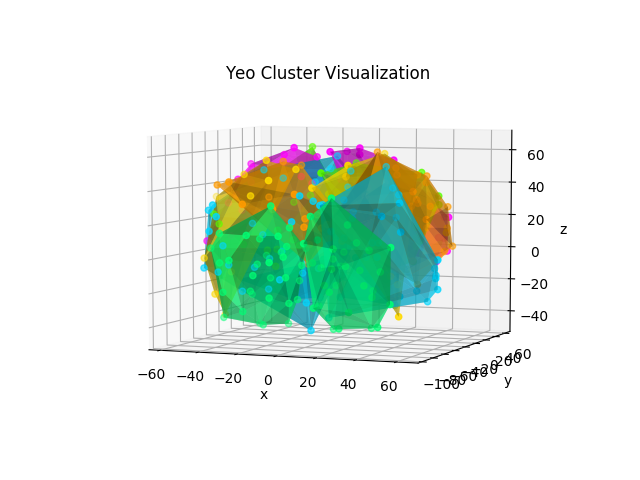

In [59]:
main = ClusterMain()
main.cluster_vis()
#main.cvt_yeo()
#main()